# Лабораторная работа 3
## Классификация изображений цветов

**Задание:**
1. Custom CNN (Conv2D + MaxPooling + Dense)
2. Transfer Learning с предобученной моделью

**Датасет:** Flowers (5 классов: daisy, dandelion, roses, sunflowers, tulips)

## 1. Импорт библиотек и конфигурация

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import keras
from keras import layers, models, regularizers, callbacks
from sklearn.metrics import (
    classification_report, confusion_matrix,
    balanced_accuracy_score, f1_score
)
import tarfile
import urllib.request

# Настройки для воспроизводимости
SEED = 42
np.random.seed(SEED)

# Параметры
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 5
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Создание директории для артефактов
ARTIFACTS_DIR = Path("lab_3_artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

print("=" * 80)
print("ЛР 3: Классификация изображений цветов")
print("=" * 80)
print(f"Keras backend: {keras.backend.backend()}")

ЛР 3: Классификация изображений цветов
Keras backend: tensorflow


## 2. Загрузка датасета

In [2]:
print("\n[1/6] Загрузка и подготовка датасета...")

# Исправление SSL ошибки на macOS
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# URL датасета
DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
DATASET_DIR = Path("flower_photos")

# Загрузка датасета, если его нет
if not DATASET_DIR.exists():
    print("Скачивание датасета...")
    archive_path = "flower_photos.tgz"
    urllib.request.urlretrieve(DATASET_URL, archive_path)

    print("Распаковка датасета...")
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall()

    os.remove(archive_path)
    print("Датасет успешно загружен и распакован")
else:
    print("Датасет уже загружен")


[1/6] Загрузка и подготовка датасета...
Скачивание датасета...
Распаковка датасета...
Датасет успешно загружен и распакован


## 3. Создание train/val/test splits

In [3]:
print("\nСоздание train/val/test splits...")

# Train: 70%, Val: 15%, Test: 15%
train_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

temp_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Разделение temp_ds на val и test (50/50 от 30%)
val_batches = int(len(temp_ds) * 0.5)
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

print(f"Train batches: {len(train_ds)}")
print(f"Val batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")


Создание train/val/test splits...
Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.
Train batches: 81
Val batches: 17
Test batches: 18


## 4. Препроцессинг и аугментация

In [4]:
print("\n[2/6] Настройка препроцессинга и аугментации...")

# Нормализация
normalization_layer = layers.Rescaling(1./255)

# Аугментация данных для обучающей выборки
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")


def prepare_dataset(ds, augment=False):
    """Подготовка датасета с нормализацией и опциональной аугментацией"""
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    ds = ds.prefetch(buffer_size=32)
    return ds


[2/6] Настройка препроцессинга и аугментации...


In [5]:
train_ds = prepare_dataset(train_ds, augment=True)
val_ds = prepare_dataset(val_ds, augment=False)
test_ds = prepare_dataset(test_ds, augment=False)

print("Препроцессинг и аугментация данных настроены")

Препроцессинг и аугментация данных настроены


## 5. Построение Custom CNN

In [6]:
print("\n[3/6] Построение моделей...")


def build_custom_cnn():
    """
    Модель 1: Custom Convolutional Neural Network
    Архитектура: Conv2D + MaxPooling + Dense классификатор
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        # Блок 1: Conv2D + MaxPooling
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Блок 2: Conv2D + MaxPooling
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Блок 3: Conv2D + MaxPooling
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Блок 4: Conv2D + MaxPooling
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Классификатор: Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='Custom_CNN')

    return model


[3/6] Построение моделей...


In [7]:
print("\nСоздание Custom CNN...")
model_custom = build_custom_cnn()

print("\nМодель 1: Custom CNN")
print(f"Всего параметров: {model_custom.count_params():,}")
model_custom.summary()


Создание Custom CNN...

Модель 1: Custom CNN
Всего параметров: 9,105,829


Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 9,105,829 (34.74 MB)

 Trainable params: 9,104,869 (34.73 MB)

 Non-trainable params: 960 (3.75 KB)

## 6. Построение Transfer Learning модели

In [9]:
def build_transfer_learning_model():
    """
    Модель 2: Transfer Learning с MobileNetV2
    Используем предобученную модель с ImageNet
    """
    # Загрузка базовой модели без верхних слоев
    base_model = keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Заморозка базовой модели
    base_model.trainable = False

    # Добавление классификатора
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='Transfer_Learning_MobileNetV2')

    return model, base_model

In [10]:
print("Создание Transfer Learning модели...")
model_transfer, base_model = build_transfer_learning_model()

print("\nМодель 2: Transfer Learning (MobileNetV2)")
print(f"Всего параметров: {model_transfer.count_params():,}")
trainable_params = sum([np.prod(w.shape) for w in model_transfer.trainable_weights])
print(f"Обучаемых параметров: {trainable_params:,}")
model_transfer.summary()

Создание Transfer Learning модели...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Модель 2: Transfer Learning (MobileNetV2)
Всего параметров: 2,624,581
Обучаемых параметров: 364,037


Model: "Transfer_Learning_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,624,581 (10.01 MB)

 Trainable params: 364,037 (1.39 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## 7. Настройка callbacks и функции обучения

In [11]:
print("\n[4/6] Обучение моделей...")

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=1e-3,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)


def train_model(model, model_name, epochs=EPOCHS):
    """Обучение модели"""
    print(f"\n{'=' * 80}")
    print(f"Обучение модели: {model_name}")
    print(f"{'=' * 80}")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=min(len(train_ds), 25),
        validation_steps=min(len(val_ds), 10),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    return history


[4/6] Обучение моделей...


## 8. Обучение Custom CNN

In [12]:
print("\n" + "=" * 80)
print("ОБУЧЕНИЕ МОДЕЛИ 1: CUSTOM CNN")
print("=" * 80)
history_custom = train_model(model_custom, "Custom CNN")


ОБУЧЕНИЕ МОДЕЛИ 1: CUSTOM CNN

Обучение модели: Custom CNN
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2537 - loss: 10.8270 - val_accuracy: 0.2406 - val_loss: 3.3410 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 924ms/step - accuracy: 0.2600 - loss: 6.3538 - val_accuracy: 0.2313 - val_loss: 3.2873 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 826ms/step - accuracy: 0.2725 - loss: 5.3934 - val_accuracy: 0.1750 - val_loss: 3.3069 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.3077 - loss: 4.2027 - val_accuracy: 0.2062 - val_loss: 3.3691 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 779ms/step - accuracy: 0.3237 - loss: 4.5212 - val_accuracy: 0.2906 - val_loss: 3.1875 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 666ms/step - accuracy: 0.3350 - loss: 4.0586 - val_accuracy: 0.2469 - val_loss: 3.2892 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━

## 9. Обучение Transfer Learning

In [13]:
print("\n" + "=" * 80)
print("ОБУЧЕНИЕ МОДЕЛИ 2: TRANSFER LEARNING")
print("=" * 80)
history_transfer = train_model(model_transfer, "Transfer Learning")


ОБУЧЕНИЕ МОДЕЛИ 2: TRANSFER LEARNING

Обучение модели: Transfer Learning
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.4800 - loss: 2.0925 - val_accuracy: 0.6938 - val_loss: 1.4502 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.6575 - loss: 1.5579 - val_accuracy: 0.7688 - val_loss: 1.2306 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6800 - loss: 1.4617 - val_accuracy: 0.8062 - val_loss: 1.1493 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7278 - loss: 1.3893 - val_accuracy: 0.7906 - val_loss: 1.1836 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.7625 - loss: 1.2700 - val_accuracy: 0.8000 - val_loss: 1.1385 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7487 - loss: 1.3346 - val_accuracy: 0.8156 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 7/30
25/2

## 10. Оценка моделей на тестовой выборке

In [14]:
print("\n[5/6] Оценка моделей на тестовой выборке...")


def evaluate_model(model, model_name):
    """Оценка модели на тестовой выборке"""
    print(f"\n{'=' * 80}")
    print(f"Тестирование модели: {model_name}")
    print(f"{'=' * 80}")

    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"\nМетрики на тестовой выборке:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    print(f"  F1-score (macro): {f1_macro:.4f}")
    print(f"  F1-score (weighted): {f1_weighted:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0
    ))

    return {
        'model_name': model_name,
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'balanced_accuracy': float(balanced_acc),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'y_true': y_true.tolist(),
        'y_pred': y_pred.tolist()
    }


[5/6] Оценка моделей на тестовой выборке...


In [15]:
results_custom = evaluate_model(model_custom, "Custom CNN")


Тестирование модели: Custom CNN

Метрики на тестовой выборке:
  Test Loss: 2.5574
  Test Accuracy: 0.3986
  Balanced Accuracy: 0.3710
  F1-score (macro): 0.3336
  F1-score (weighted): 0.3340

Classification Report:
              precision    recall  f1-score   support

       daisy     0.3125    0.0568    0.0962        88
   dandelion     0.3359    0.6397    0.4405       136
       roses     0.2636    0.3187    0.2886        91
  sunflowers     0.6316    0.7200    0.6729       100
      tulips     0.2931    0.1197    0.1700       142

    accuracy                         0.3770       557
   macro avg     0.3673    0.3710    0.3336       557
weighted avg     0.3626    0.3770    0.3340       557



In [16]:
results_transfer = evaluate_model(model_transfer, "Transfer Learning")


Тестирование модели: Transfer Learning

Метрики на тестовой выборке:
  Test Loss: 1.0028
  Test Accuracy: 0.8312
  Balanced Accuracy: 0.8367
  F1-score (macro): 0.8350
  F1-score (weighted): 0.8370

Classification Report:
              precision    recall  f1-score   support

       daisy     0.8590    0.8375    0.8481        80
   dandelion     0.9118    0.8857    0.8986       140
       roses     0.7373    0.8365    0.7838       104
  sunflowers     0.8288    0.8679    0.8479       106
      tulips     0.8421    0.7559    0.7967       127

    accuracy                         0.8366       557
   macro avg     0.8358    0.8367    0.8350       557
weighted avg     0.8399    0.8366    0.8370       557



## 11. Визуализация: графики обучения

In [17]:
print("\n[6/6] Создание визуализаций...")


def plot_training_history(history, model_name):
    """Графики обучения"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title(f'{model_name}: Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title(f'{model_name}: Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    filename = f"training_history_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(ARTIFACTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"  Saved: {filename}")


[6/6] Создание визуализаций...


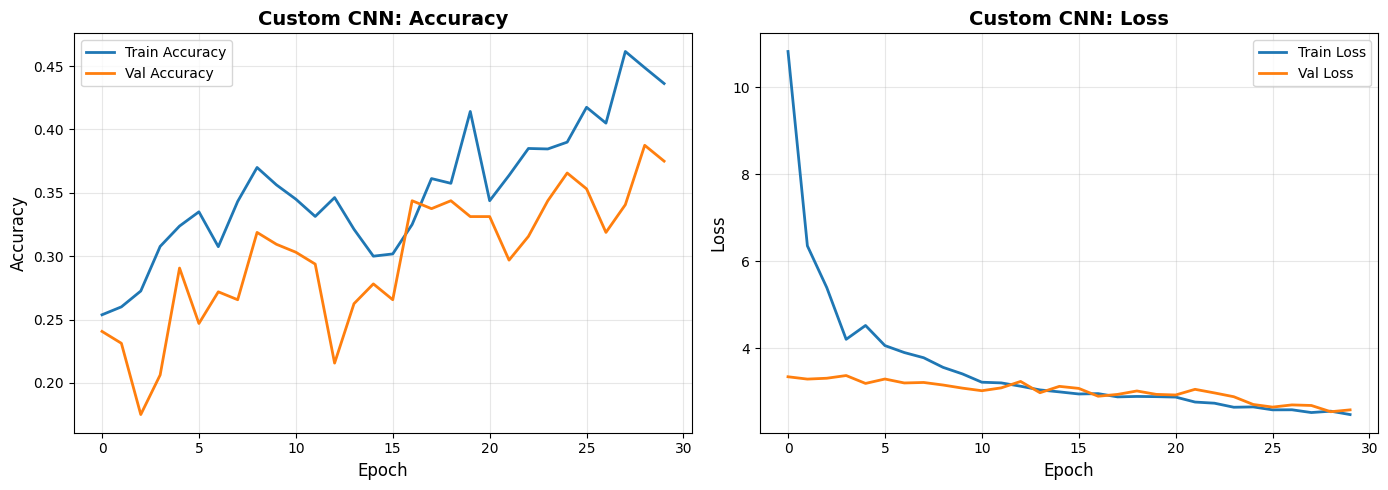

  Saved: training_history_custom_cnn.png


In [18]:
plot_training_history(history_custom, "Custom CNN")

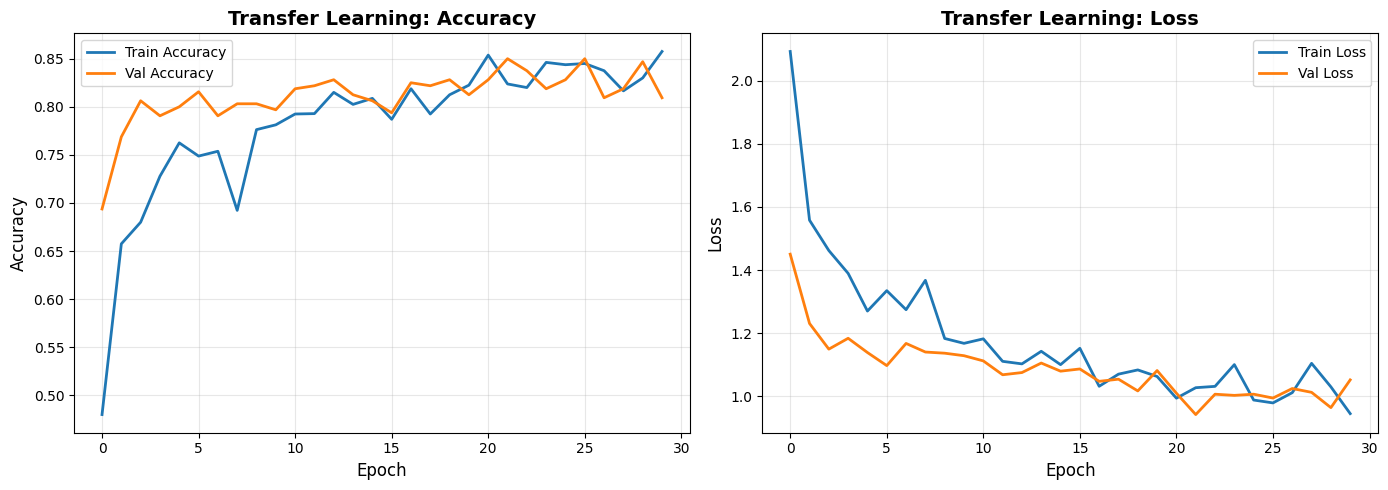

  Saved: training_history_transfer_learning.png


In [19]:
plot_training_history(history_transfer, "Transfer Learning")

## 12. Визуализация: Confusion Matrix

In [20]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Confusion Matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{model_name}: Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()

    filename = f"confusion_matrix_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(ARTIFACTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"  Saved: {filename}")

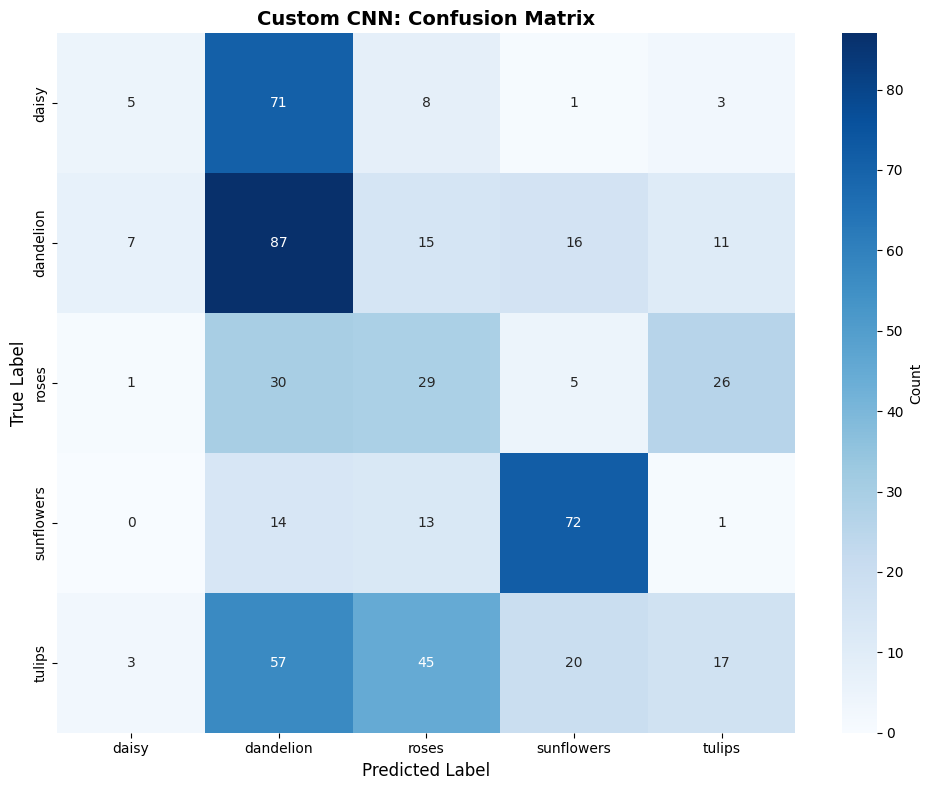

  Saved: confusion_matrix_custom_cnn.png


In [21]:
plot_confusion_matrix(results_custom['y_true'], results_custom['y_pred'], "Custom CNN")

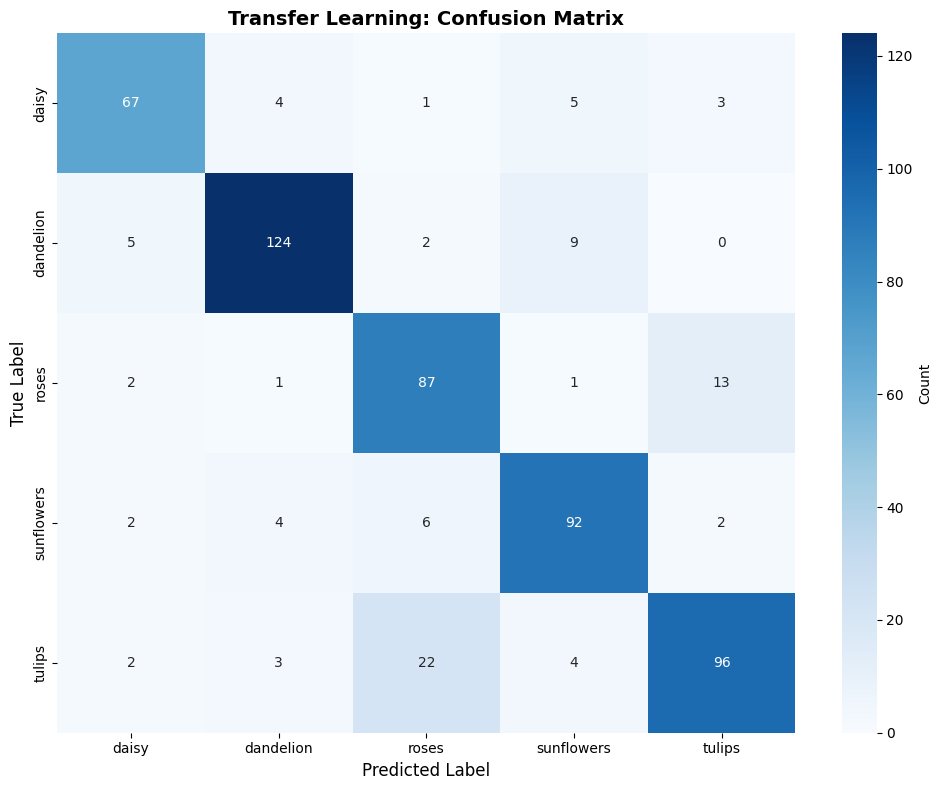

  Saved: confusion_matrix_transfer_learning.png


In [22]:
plot_confusion_matrix(results_transfer['y_true'], results_transfer['y_pred'], "Transfer Learning")

## 13. Визуализация: сравнение моделей

In [23]:
def plot_comparison(results_list):
    """Сравнение моделей"""
    models_names = [r['model_name'] for r in results_list]
    metrics = ['test_accuracy', 'balanced_accuracy', 'f1_macro', 'f1_weighted']
    metric_names = ['Accuracy', 'Balanced Acc', 'F1 Macro', 'F1 Weighted']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
        values = [r[metric] for r in results_list]
        bars = axes[idx].bar(models_names, values, color=['#3498db', '#e74c3c'], alpha=0.8)
        axes[idx].set_ylabel(name, fontsize=12)
        axes[idx].set_title(f'Сравнение: {name}', fontsize=13, fontweight='bold')
        axes[idx].set_ylim([min(values) - 0.05, 1.0])
        axes[idx].grid(True, alpha=0.3, axis='y')

        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold'
            )

    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / "models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"  Saved: models_comparison.png")

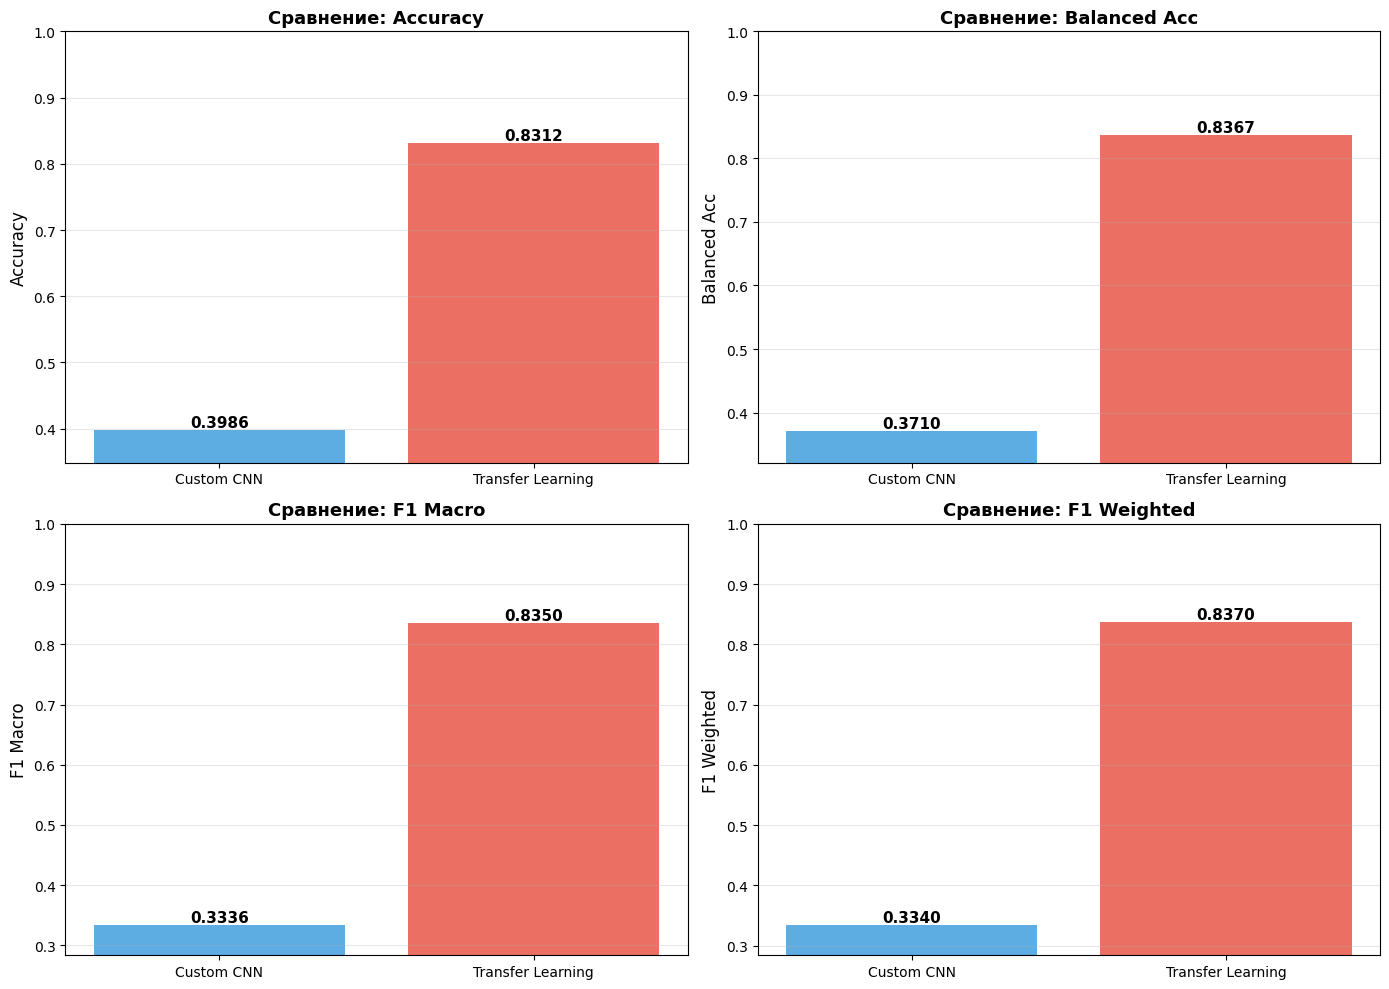

  Saved: models_comparison.png


In [24]:
plot_comparison([results_custom, results_transfer])

## 14. Визуализация: примеры предсказаний

In [25]:
def visualize_sample_predictions(model, model_name, dataset):
    """Визуализация примеров предсказаний"""
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        pred_classes = np.argmax(predictions, axis=1)

        num_samples = min(12, len(images))
        indices = list(range(num_samples))

        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.ravel()

        for idx, img_idx in enumerate(indices):
            if idx >= len(axes):
                break

            img = images[img_idx].numpy()
            true_label = int(labels[img_idx].numpy())
            pred_label = pred_classes[img_idx]
            confidence = predictions[img_idx][pred_label]

            axes[idx].imshow(img)
            axes[idx].axis('off')

            color = 'green' if true_label == pred_label else 'red'
            title = f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]} ({confidence:.2%})"
            axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')

        for idx in range(num_samples, len(axes)):
            axes[idx].axis('off')

        plt.suptitle(f'{model_name}: Sample Predictions', fontsize=14, fontweight='bold')
        plt.tight_layout()

        filename = f"sample_predictions_{model_name.lower().replace(' ', '_')}.png"
        plt.savefig(ARTIFACTS_DIR / filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"  Saved: {filename}")
        break

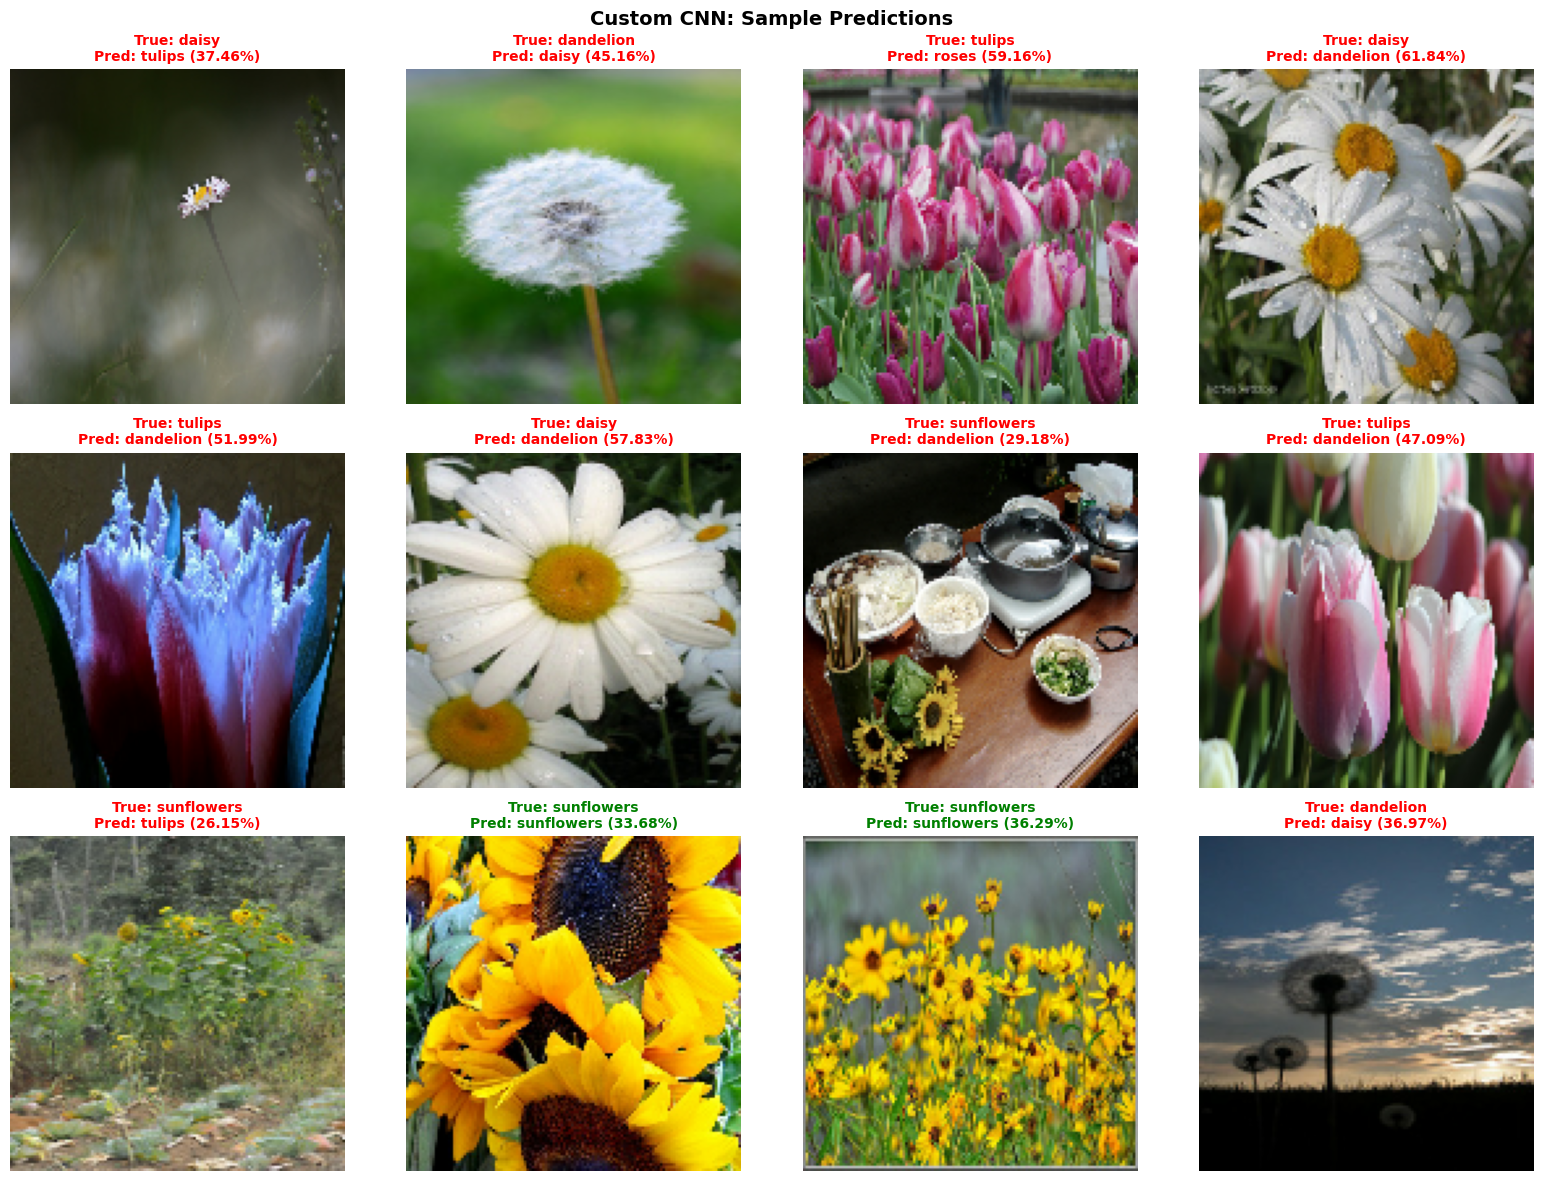

  Saved: sample_predictions_custom_cnn.png


In [26]:
visualize_sample_predictions(model_custom, "Custom CNN", test_ds)

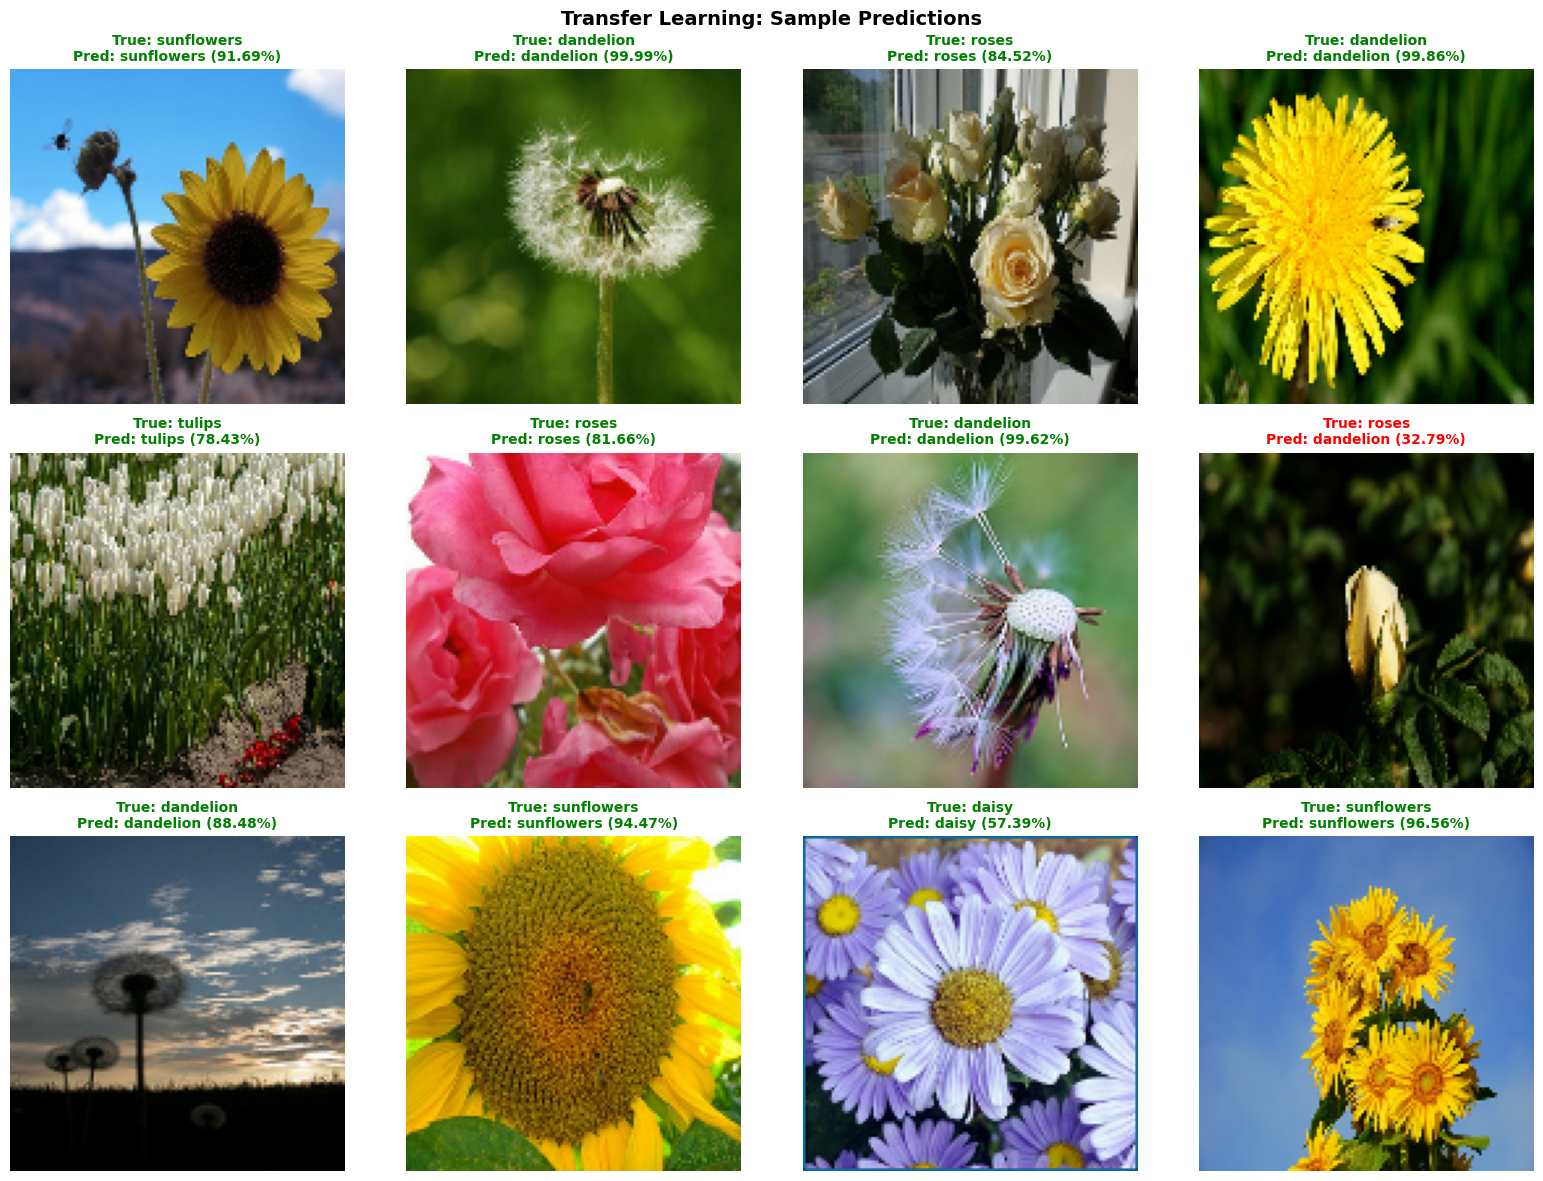

  Saved: sample_predictions_transfer_learning.png


In [27]:
visualize_sample_predictions(model_transfer, "Transfer Learning", test_ds)

## 15. Сохранение результатов

In [28]:
# Получение размеров датасетов
train_size = sum([len(labels) for _, labels in train_ds])
val_size = sum([len(labels) for _, labels in val_ds])
test_size = sum([len(labels) for _, labels in test_ds])

# Сохранение сводки результатов
summary = {
    'dataset': {
        'name': 'Flower Photos',
        'num_classes': NUM_CLASSES,
        'classes': CLASS_NAMES,
        'train_size': int(train_size),
        'val_size': int(val_size),
        'test_size': int(test_size),
        'image_size': IMG_SIZE,
        'batch_size': BATCH_SIZE
    },
    'models': {
        'custom_cnn': {
            'params': int(model_custom.count_params()),
            'epochs_trained': len(history_custom.history['loss']),
            'metrics': {
                'test_loss': results_custom['test_loss'],
                'test_accuracy': results_custom['test_accuracy'],
                'balanced_accuracy': results_custom['balanced_accuracy'],
                'f1_macro': results_custom['f1_macro'],
                'f1_weighted': results_custom['f1_weighted']
            }
        },
        'transfer_learning': {
            'base_model': 'MobileNetV2',
            'params_total': int(model_transfer.count_params()),
            'params_trainable': int(trainable_params),
            'epochs_trained': len(history_transfer.history['loss']),
            'metrics': {
                'test_loss': results_transfer['test_loss'],
                'test_accuracy': results_transfer['test_accuracy'],
                'balanced_accuracy': results_transfer['balanced_accuracy'],
                'f1_macro': results_transfer['f1_macro'],
                'f1_weighted': results_transfer['f1_weighted']
            }
        }
    }
}

with open(ARTIFACTS_DIR / 'results_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"\n  Saved: results_summary.json")


  Saved: results_summary.json


In [29]:
# Сохранение моделей
model_custom.save(ARTIFACTS_DIR / 'model_custom_cnn.keras')
model_transfer.save(ARTIFACTS_DIR / 'model_transfer_learning.keras')
print(f"  Saved: model_custom_cnn.keras")
print(f"  Saved: model_transfer_learning.keras")

  Saved: model_custom_cnn.keras
  Saved: model_transfer_learning.keras


## 16. Итоговое сравнение

In [30]:
print("\n" + "=" * 80)
print("АНАЛИЗ ЗАВЕРШЕН")
print("=" * 80)
print(f"\nРезультаты сохранены в: {ARTIFACTS_DIR}/")
print("\nСравнение моделей:")
print(f"{'Метрика':<20} {'Custom CNN':>15} {'Transfer Learning':>20}")
print("-" * 60)
print(f"{'Test Accuracy':<20} {results_custom['test_accuracy']:>15.4f} {results_transfer['test_accuracy']:>20.4f}")
print(f"{'Balanced Accuracy':<20} {results_custom['balanced_accuracy']:>15.4f} {results_transfer['balanced_accuracy']:>20.4f}")
print(f"{'F1-score (macro)':<20} {results_custom['f1_macro']:>15.4f} {results_transfer['f1_macro']:>20.4f}")
print(f"{'F1-score (weighted)':<20} {results_custom['f1_weighted']:>15.4f} {results_transfer['f1_weighted']:>20.4f}")

# Определение лучшей модели
best_model = "Transfer Learning" if results_transfer['test_accuracy'] > results_custom['test_accuracy'] else "Custom CNN"
print(f"\nЛучшая модель: {best_model}")
print("=" * 80)


АНАЛИЗ ЗАВЕРШЕН

Результаты сохранены в: lab_3_artifacts/

Сравнение моделей:
Метрика                   Custom CNN    Transfer Learning
------------------------------------------------------------
Test Accuracy                 0.3986               0.8312
Balanced Accuracy             0.3710               0.8367
F1-score (macro)              0.3336               0.8350
F1-score (weighted)           0.3340               0.8370

Лучшая модель: Transfer Learning
